In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer,  OrdinalEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import Ridge, Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from warnings import filterwarnings

filterwarnings('ignore')

%matplotlib inline

sns.set(style="darkgrid")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

**Task 1**. We will be working with data from the [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) competition, which was about predicting the duration of a taxi trip. Download the training sample from this competition and upload it:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!rm -r ./data
!mkdir ./data/

with zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

rm: cannot remove './data': No such file or directory


In [ ]:
train = pd.read_csv('./data/train.csv')

In [ ]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Pay attention to the `pickup_datetime` and `dropoff_datetime` columns. `dropoff_datetime` was added only to the training sample, so, this column cannot be used, let's delete it. `pickup_datetime` contains the date and time the trip started. To make it convenient to work with, let's convert dates to `datetime` objects

In [ ]:
train = train.drop('dropoff_datetime', axis=1)
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)

target = 'trip_duration'

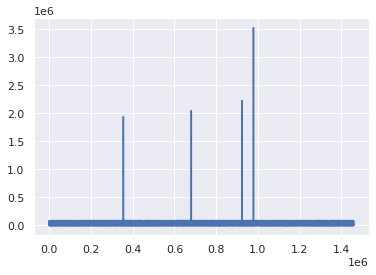

In [ ]:
train.trip_duration.plot()

In [ ]:
train.trip_duration

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

The `trip_duration` column contains the target value we want to predict. Let's look at the distribution of the target in the training sample. To do this, draw its histogram:

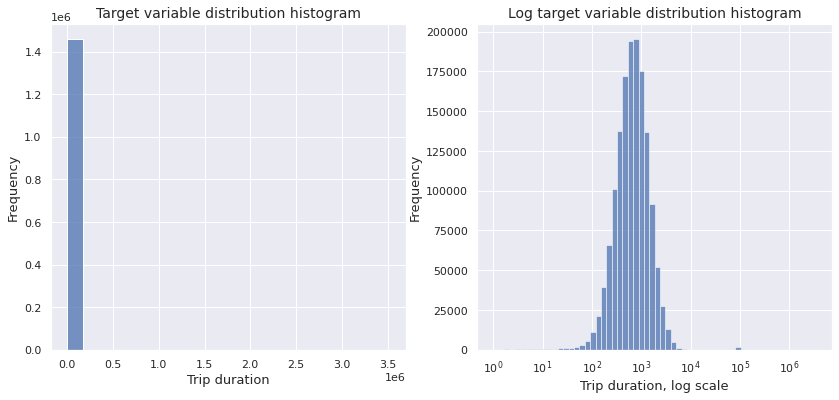

In [ ]:
plt.rcParams["figure.figsize"] = (14,6)

fig, ax = plt.subplots(ncols=2)

sns.histplot(data=train, x=target, bins=20, ax=ax[0])
#plot similar histogram with parameter log_scale, choose informative amount of bins and correct axis
#your code here
sns.histplot(data = train, x=target,log_scale = True,
             bins= 60,  ax= ax[1])
#end of your code


ax[0].set_title('Target variable distribution histogram', dict(size=14))
ax[0].set_xlabel('Trip duration', dict(size=13))
ax[0].set_ylabel('Frequency', dict(size=13))

ax[1].set_title('Log target variable distribution histogram', dict(size=14))
ax[1].set_xlabel('Trip duration, log scale', dict(size=13))
_ = ax[1].set_ylabel('Frequency', dict(size=13))

**Question**: Why is it necessary to build a histogram in a logarithmic scale?

**Answer**

The competition used RMSLE as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: Why do you think the contest authors chose RMSLE and not RMSE?

**Answer**

We have discussed several linear regression models in `sklearn`, but each of them optimized the mean square error (MSE), not RMSLE. Let's do the following trick: we will predict not the target variable, but its *logarithm*. Let $\hat{y}_i = \log{(y_i + 1)}$ be the modified target, and $\hat{a}(x_i)$ be the prediction of the model trained on $\hat{y}_i$, that is, the logarithm of the target. To predict the original value, we can simply take the exponent of our prediction: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In addition, the logarithm of the target has another useful quality. To see it, add the `log_trip_duration` column to our sample (use `np.log1p`) and draw a histogram of the modified target for the training sample. Delete the column with the old target.

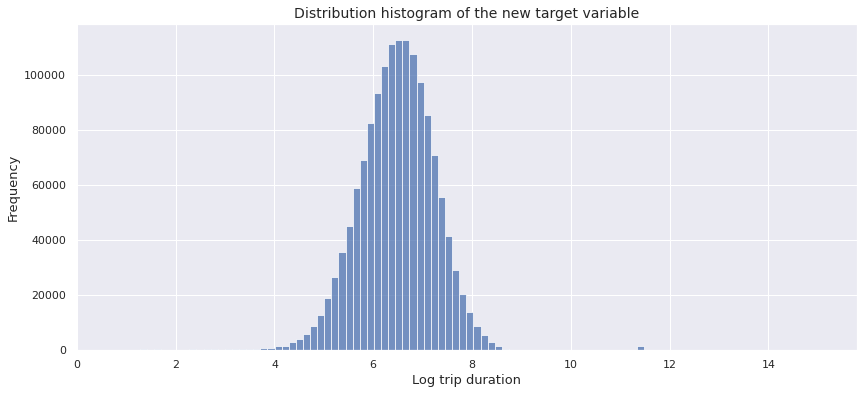

In [ ]:
train['log_trip_duration'] = np.log1p(train[target])
#your code to delet target column from train is here:
train.drop(columns=['trip_duration'], inplace = True)
#end of your code
target = 'log_trip_duration'

plt.title('Distribution histogram of the new target variable', dict(size=14))
plt.xlabel('Log trip duration', dict(size=13))
plt.ylabel('Frequency', dict(size=13))
_ = sns.histplot(data=train, x=target, bins=100)

Let's calculate the value of the metric with the best constant prediction:

**Question**: why the best constant for RMSE is mean value?

**Answer**:

In [ ]:
train.log_trip_duration.describe()

count    1.458644e+06
mean     6.466978e+00
std      7.957595e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.496775e+00
75%      6.981006e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64

In [ ]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

In [ ]:
#your code to find constant prediction here:
score = 15
for i in range(50, 80):
  score_new = RMSE(train[target], i/10)
  if score_new < score:
    score = score_new
    const_model = i/10

#end of your code
print('Constant {0} provides the best constant prediction value: {1}'.format( const_model ,RMSE(train[target], const_model)))

Constant 6.5 provides the best constant prediction value: 0.7964440896843196


The value closest to the mean provides the best constant prediction, because we have centralised distribution, and the mean provides lowest variance. RMSE rewards low variance, and penalises big variance by squaring the deviation. 

**Task 2**. First, let's see how many trips there were on each day. Plot the number of trips versus the day of the year:

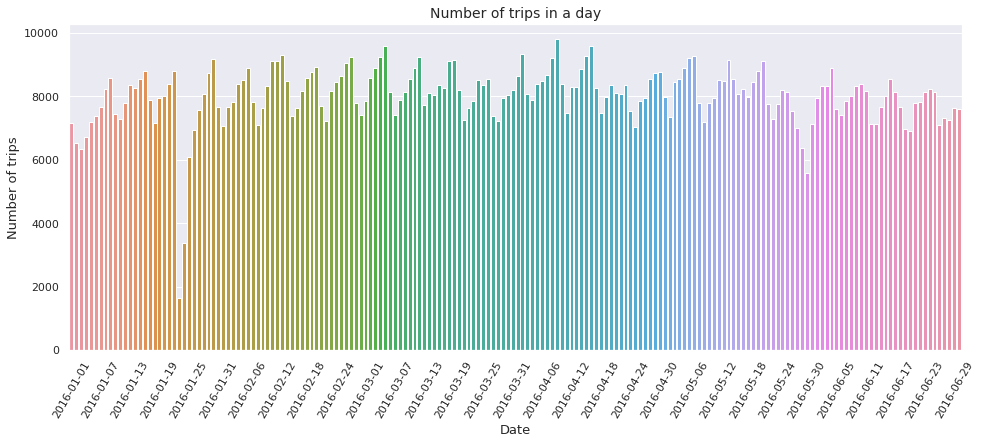

In [ ]:
plt.rcParams["figure.figsize"] = (16,6)
train['day_of_year'] = train.pickup_datetime.dt.day_of_year

sns.countplot(x=train['day_of_year'])

plt.title('Number of trips in a day', dict(size=14))
plt.xlabel('Date', dict(size=13))
plt.ylabel('Number of trips', dict(size=13))

_ = plt.xticks(np.arange(0, 181, 6), np.unique(train.pickup_datetime.dt.date)[::6], rotation=60)

**Question**: You may have noticed that there are 2 periods on the graph with abnormally low numbers of trips. Calculate the dates on which these downward swings occurred and find information about what happened on those days in New York.

**Answer**:



Plot the number of trips versus the day of the week and the hours of the day (use `sns.relplot`):

In [ ]:
train['date'] = train['pickup_datetime'].dt.date

In [ ]:

train.groupby('date').agg({'id':'count'}).reset_index().sort_values('id', ascending = True).head(5)

,date,id
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570
24,2016-01-25,6084
2,2016-01-03,6353


We got 2 outliers - january 23rd and 24th of 2016. Also a small drop on 25th of May. As for January the reason is pretty obvious


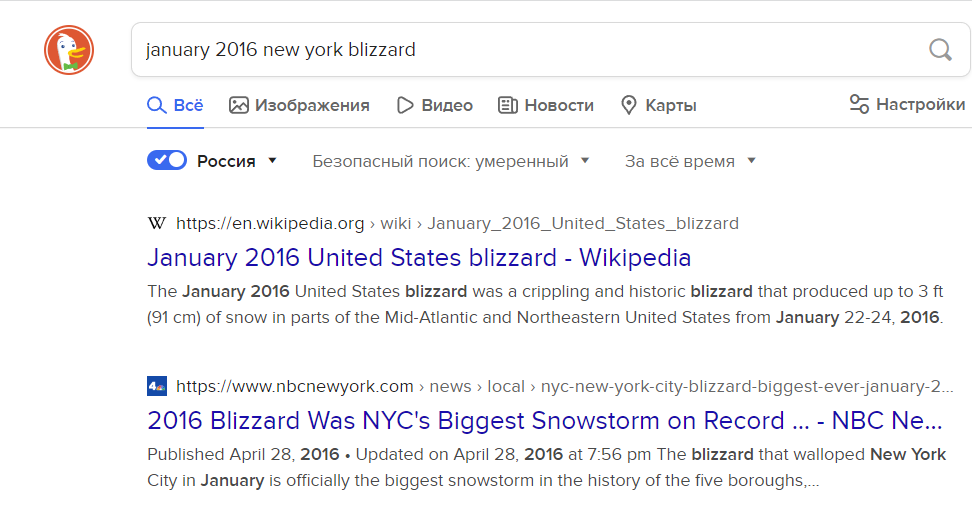

But as for may, it is more interesting. However after extensive googling I found this 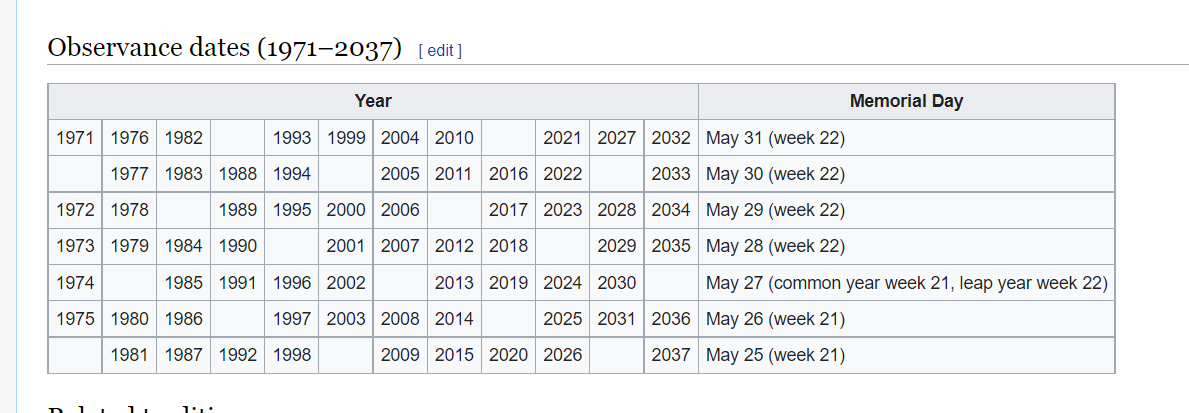

So the drop is likely connected to Memorial Day festivities, parades etc.

In [ ]:
train['hour'] = train.pickup_datetime.dt.hour
train['day_of_week'] = train.pickup_datetime.dt.day_of_week
train['day_of_year'] = train.pickup_datetime.dt.day_of_year
train['month_name'] = train.pickup_datetime.dt.month_name()

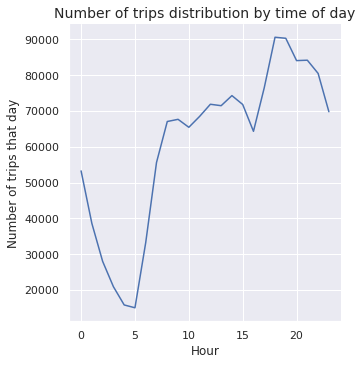

In [ ]:
tmp_data = train.groupby('hour').id.count()\
.reset_index().rename({
    'hour': 'Hour',
    'id': 'Number of trips that day'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips that day',
            kind='line')
_ = plt.title('Number of trips distribution by time of day', dict(size=14))

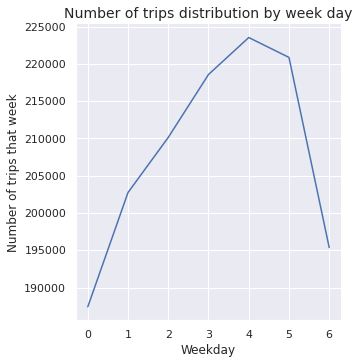

In [ ]:
#your code for number of trips distribution by day of week
tmp_data = train.groupby('day_of_week').id.count()\
.reset_index().rename({
    'day_of_week': 'Weekday',
    'id': 'Number of trips that week'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Weekday',
            y='Number of trips that week',
            kind='line')
_ = plt.title('Number of trips distribution by week day', dict(size=14))

#end of your code

spikes at friday and saturday are expected. however overall seasonality from monday to saturday is interesting.

**Task 3**. Draw on one graph the dependence of the number of trips on the hour of the day for different months (different curves corresponding to different months, color in different colors with use of `hue` in `sns.relplot`). Similarly, draw the dependence of the number of trips on the hour of the day for different days of the week.

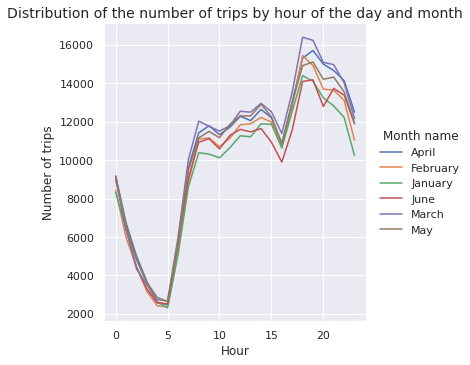

In [ ]:
tmp_data = train.groupby(['month_name', 'hour']).id.count()\
.reset_index().rename({
    'month_name': 'Month name',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)

sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Month name',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))

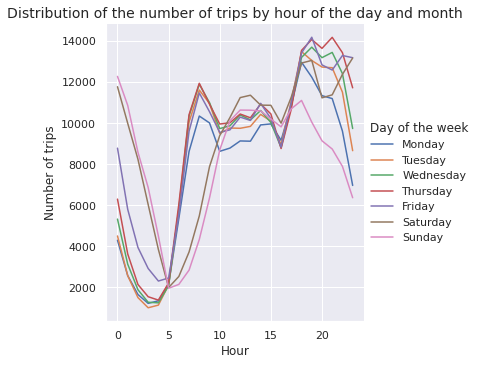

In [ ]:
#your code for the dependence of the number of trips on the hour of the day for different days of the week is here:

tmp_data = train.groupby(['day_of_week', 'hour']).id.count()\
.reset_index().rename({
    'day_of_week': 'Day of the week',
    'hour': 'Hour',
    'id': 'Number of trips'},
    axis=1
)
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
for i in range(7):
  tmp_data['Day of the week'] = tmp_data['Day of the week'].replace(i,days[i])
sns.relplot(data=tmp_data,
            x='Hour',
            y='Number of trips',
            hue='Day of the week',
            kind='line')
_ = plt.title('Distribution of the number of trips by hour of the day and month', dict(size=14))
#end of your code

**Question**: What conclusions can be drawn based on the graphs above? Are there any special days of the week? Months? Times of Day? What is it connected with?

**Answer**:
If we look at months, there is no apparent seasonality, there is a fall in June in the afternoon, which might be connected to nice weather and the desire to take a walk. There also is a spike in the March evenings and mornings, which might be connected to nasty weather. Looking at the weekdays, There is a night spike for Saturday and Sunday which is obvious and connected to having nights out on the weekends. Sunday night being the end of Saturday and Saturday night being the end of Friday. Quite peculiar that Friday night (End of Thursday) also stands out, perhaps a number of people in New York have 4 day work weeks. Then there's also depressed number of rides at Sunday evening, explained by people preparing for Monday and staying at home. Additionaly one interesting point is how work days have more rides around 8 in the morning, where people are commuting. While at the same hour on Saturday and Sunday the number of rides is very low. 

**Task 4**. Split the sample into train and test (7:3). For the train sample, plot the mean logarithm of travel time versus day of the week. Then do the same, but for the hour of the day and the day of the year.

Add the following traits based on `pickup_datetime`:
1. Day of the week
2. Month
3. Hour
4. Is the period anomalous (two binary signs corresponding to two anomalous periods)
5. Number of the day in the year

In [ ]:
train = train.drop('month_name', axis=1)
train['month'] = train.pickup_datetime.dt.month

train['is_anomaly_jan'] = ((23 <= train.day_of_year) & (train.day_of_year <= 26)).astype('int')
train['is_anomaly_may'] = (train.day_of_year == 151).astype('int')

In [ ]:
#your code for splitting is here:
train_data, test_data = train_test_split(train, test_size=0.3, random_state=42)
#end of ypur code

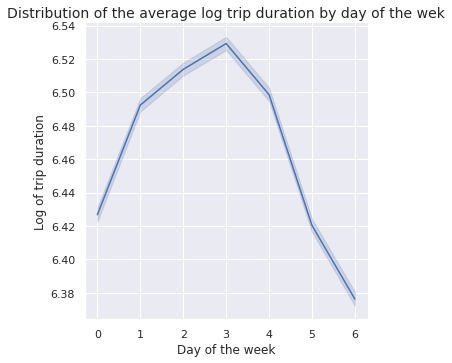

In [ ]:
#your code for distribution of average trip duration by the number of day in a week is here:
sns.relplot(data=train_data.rename({
    'day_of_week': 'Day of the week',
    'log_trip_duration': 'Log of trip duration'},
    axis=1
),
            x='Day of the week',
            y='Log of trip duration',
            kind='line')
_ = plt.title('Distribution of the average log trip duration by day of the wek', dict(size=14))
#end of your code

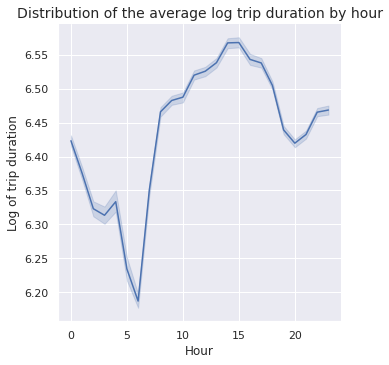

In [ ]:
#your code for distribution of average trip duration by the hour of day is here:
sns.relplot(data=train_data.rename({
    'hour': 'Hour',
    'log_trip_duration': 'Log of trip duration'},
    axis=1
),
            x='Hour',
            y='Log of trip duration',
            kind='line')
_ = plt.title('Distribution of the average log trip duration by hour', dict(size=14))
#end of your code

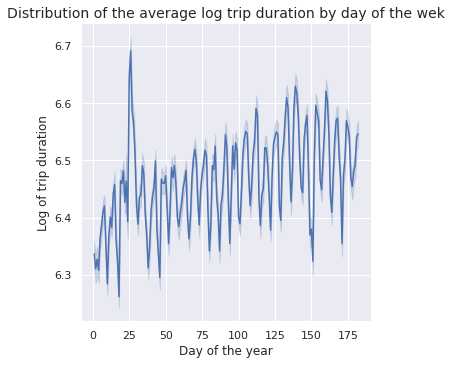

In [ ]:
#your code for distribution of average trip duration by the number of day in the year is here:
sns.relplot(data=train_data.rename({
    'day_of_year': 'Day of the year',
    'log_trip_duration': 'Log of trip duration'},
    axis=1
),
            x='Day of the year',
            y='Log of trip duration',
            kind='line')
_ = plt.title('Distribution of the average log trip duration by day of the wek', dict(size=14))
#end of your code

**Question**: Are the graphs of the target depending on the day of the week and on the hour of the day similar to those for the number of trips? Why? What happens to the average target in those two anomalous periods that we saw above? Why is this happening? Do you see any trend in the plot of `log_trip_duration` versus day of the year?

**Answer**: The hourly graph is very similar, the weekly graph is a bit shifted. The peak for number of rides was on friday and saturday, while the longest durations are on Wednesday and Thursday. And yearly graph is different, with number of rides either stagnating or slightly decreasing juxtaposed to the upward trend in duration. For the blizzard days the log duration is extremely high, due to, well, the blizzard. High duration with low number of trips indicates supply bottlenecks, or road closures. For the Memorial Day the log of duration is small, which indicates that low number of trips is because of the small demand. There is something that looks like linear upward trend in the log of trip duration. A linear trend in log indicates exponential trend in the variable itself. 

So, we have already created a number of features.

**Question**: Which of the features should be considered as categorical, and which - as numerical? Why?

**Answer**: Passenger count is obiously numerical, the rest should be categorical, because there is no numerical sense behind other variables. Additionally coordinates cannot be used neither as numerical nor as categorical. In order to use them effectively they need to be clusterised and then categorised

In [ ]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,date,hour,day_of_week,month,is_anomaly_jan,is_anomaly_may
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,N,6.122493,74,2016-03-14,17,0,3,0,0


**Task 5**. Train `Ridge` regression with default parameters by encoding all categorical features with `OneHotEncoder`. Scale numerical features with `StandardScaler`. Use only the features that we have identified in this part of the task.

In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [ ]:

#your list of categorical features is here:
categorical_columns = ['vendor_id','store_and_fwd_flag','day_of_year','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may']
#your list of numerical features is here:
numeric_columns = ['passenger_count']
#your code to create pipeline is here:
model = Ridge(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

Train RMSE is 0.7876097466734705
Test RMSE is 0.7867374335304893


**Task 6**. Try to use any other way of categorical features encoding and normalization for numerical features. Train `Ridge` and `Lasso` regression for various encoding options and evaluate the results. Which one turned out to be the best? Why did other options show worse quality?

In [ ]:
#your code is here
model = Lasso(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643


In [ ]:
#your code is here  , MinMaxScaler, MaxAbsScaler
model = Lasso(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OrdinalEncoder(), StandardScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.7953829995660648
Test RMSE is 0.7943622857209748


In [ ]:
#your code is here
model = Lasso(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), MinMaxScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643


In [ ]:
#your code is here
model = Lasso(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), MaxAbsScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.796072872850926
Test RMSE is 0.795026955552643


In [ ]:
#your code is here
model = Ridge(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), MaxAbsScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.7876097512572552
Test RMSE is 0.7867374681030698


In [ ]:
#your code is here
model = Ridge(alpha=1.0)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), MinMaxScaler())
#end of ypur code
fit_pipeline(pipeline, *train_test_split(train, random_state=42, test_size=0.3))

#end of your code

Train RMSE is 0.7876097512572552
Test RMSE is 0.7867374681030698


Ridge with standard scaler and onehot encoder turned out to be the best option. One-hot is the better than Ordinal encoding because ordinal codes categorial values with ordinal integers 1,2,3,5 etc. this is worse for regression than having a lot of binary variables because it implies some numerical order where 5>1 which is not true for categorical variables. StandardScaler performed pretty much the same (up to like 6th digit) as other scalers. And Ridge model is a bit better than Lasso because we do not have a lot of categorical variables and Lasso drops some of them, which might effect predictions, while Ridge just tones down coefficients for those variables.  

**Task 7**. Split the training sample into train and validation (8:2). On the validation set, find the optimal values of the regularization parameter (on a logarithmic grid) for `Ridge` and `Lasso`, measure the quality of the best obtained model on the test set.

In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    #print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    #print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))
    return RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))

In [ ]:
rmse = 1 
i_target  = 0
trainset, testset = train_test_split(train, random_state=42, test_size=0.3)
doubletrain, val =  train_test_split(trainset, random_state=42, test_size=0.2)
#your code is here
for i in range(1, 100):
  model = Ridge(alpha=i/10)
  pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
  #end of ypur code
  print('alpha is {}'.format(i/10))
  rmse_new = fit_pipeline(pipeline, doubletrain, val)
  if rmse_new < rmse:
    rmse = rmse_new
    i_target = i/10
#end of your code

alpha is 0.1
alpha is 0.2
alpha is 0.3
alpha is 0.4
alpha is 0.5
alpha is 0.6
alpha is 0.7
alpha is 0.8
alpha is 0.9
alpha is 1.0
alpha is 1.1
alpha is 1.2
alpha is 1.3
alpha is 1.4
alpha is 1.5
alpha is 1.6
alpha is 1.7
alpha is 1.8
alpha is 1.9
alpha is 2.0
alpha is 2.1
alpha is 2.2
alpha is 2.3
alpha is 2.4
alpha is 2.5
alpha is 2.6
alpha is 2.7
alpha is 2.8
alpha is 2.9
alpha is 3.0
alpha is 3.1
alpha is 3.2
alpha is 3.3
alpha is 3.4
alpha is 3.5
alpha is 3.6
alpha is 3.7
alpha is 3.8
alpha is 3.9
alpha is 4.0
alpha is 4.1
alpha is 4.2
alpha is 4.3
alpha is 4.4
alpha is 4.5
alpha is 4.6
alpha is 4.7
alpha is 4.8
alpha is 4.9
alpha is 5.0
alpha is 5.1
alpha is 5.2
alpha is 5.3
alpha is 5.4
alpha is 5.5
alpha is 5.6
alpha is 5.7
alpha is 5.8
alpha is 5.9
alpha is 6.0
alpha is 6.1
alpha is 6.2
alpha is 6.3
alpha is 6.4
alpha is 6.5
alpha is 6.6
alpha is 6.7
alpha is 6.8
alpha is 6.9
alpha is 7.0
alpha is 7.1
alpha is 7.2
alpha is 7.3
alpha is 7.4
alpha is 7.5
alpha is 7.6
alpha is 7.7

In [ ]:
print(i_target, rmse)

6.1 0.7855242750535312


In [ ]:
rmse = 1 
i_target  = 0
trainset, testset = train_test_split(train, random_state=42, test_size=0.3)
doubletrain, val =  train_test_split(trainset, random_state=42, test_size=0.2)
#your code is here
for i in range(1, 100):
  model = Lasso(alpha=i/100)
  pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
  #end of ypur code
  print('alpha is {}'.format(i/100))
  rmse_new = fit_pipeline(pipeline, doubletrain, val)
  if rmse_new < rmse:
    rmse = rmse_new
    i_target = i/100
#end of your code

alpha is 0.01
alpha is 0.02
alpha is 0.03
alpha is 0.04
alpha is 0.05
alpha is 0.06
alpha is 0.07
alpha is 0.08
alpha is 0.09
alpha is 0.1
alpha is 0.11
alpha is 0.12
alpha is 0.13
alpha is 0.14
alpha is 0.15
alpha is 0.16
alpha is 0.17
alpha is 0.18
alpha is 0.19
alpha is 0.2
alpha is 0.21
alpha is 0.22
alpha is 0.23
alpha is 0.24
alpha is 0.25
alpha is 0.26
alpha is 0.27
alpha is 0.28
alpha is 0.29
alpha is 0.3
alpha is 0.31
alpha is 0.32
alpha is 0.33
alpha is 0.34
alpha is 0.35
alpha is 0.36
alpha is 0.37
alpha is 0.38
alpha is 0.39
alpha is 0.4
alpha is 0.41
alpha is 0.42
alpha is 0.43
alpha is 0.44
alpha is 0.45
alpha is 0.46
alpha is 0.47
alpha is 0.48
alpha is 0.49
alpha is 0.5
alpha is 0.51
alpha is 0.52
alpha is 0.53
alpha is 0.54
alpha is 0.55
alpha is 0.56
alpha is 0.57
alpha is 0.58
alpha is 0.59
alpha is 0.6
alpha is 0.61
alpha is 0.62
alpha is 0.63
alpha is 0.64
alpha is 0.65
alpha is 0.66
alpha is 0.67
alpha is 0.68
alpha is 0.69
alpha is 0.7
alpha is 0.71
alpha is 0.72

In [ ]:
print(i_target, rmse)

0.01 0.7937469386824388


In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [ ]:
model = Ridge(alpha=6.1)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
rmse_new = fit_pipeline(pipeline, trainset, testset)

Train RMSE is 0.7876097481851347
Test RMSE is 0.7867373252528412


In [ ]:
model = Lasso(alpha=0.01)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
rmse_new = fit_pipeline(pipeline, trainset, testset)

Train RMSE is 0.7957053707393592
Test RMSE is 0.7946598439640655


**Task 8**. Find data, which describes weather in New York during 2016 year. Add some features, based on this data and find new quality of your best model.

In [ ]:
#your code is here

weather = pd.read_csv('/content/drive/MyDrive/weather_data_nyc_centralpark_2016(1).csv')
#end of your code

In [ ]:
weather['date'] = pd.to_datetime(weather['date'])

In [ ]:
weather

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-02-01,40,32,36.0,0.00,0.0,0
2,2016-03-01,45,35,40.0,0.00,0.0,0
3,2016-04-01,36,14,25.0,0.00,0.0,0
4,2016-05-01,29,11,20.0,0.00,0.0,0
...,...,...,...,...,...,...,...
361,2016-12-27,60,40,50.0,0,0,0
362,2016-12-28,40,34,37.0,0,0,0
363,2016-12-29,46,33,39.5,0.39,0,0
364,2016-12-30,40,33,36.5,0.01,T,0


We will need to create 2 dummy variables for T in snowfall and precipitation. T means a bit higher than 0 but not measurable. As such we will have variables which have 1 if any snow or rain was present and 0 otherwise

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train = train.merge(weather, on = 'date', how = 'left')

In [ ]:
train['precipitation_reg'] = np.where(train['precipitation'] == 'T', 1, 0)
train['snow_fall_reg'] = np.where(train['snow fall'] == 'T', 1, 0)
train['snow_depth_reg'] = np.where(train['snow depth'] == 'T', 1, 0)
train[['precipitation','snow fall','snow depth']] = train[['precipitation','snow fall','snow depth']].replace('T', 0)
train[['precipitation','snow fall','snow depth']] = train[['precipitation','snow fall','snow depth']].astype('float')

In [ ]:
train['precipitation_reg'] = np.where(train['precipitation'] > 0.0, 1, np.where(train['precipitation_reg'] ==1,1,0))
train['snow_fall_reg'] = np.where(train['snow fall'] > 0.0, 1,  np.where(train['snow_fall_reg'] ==1,1,0))
train['snow_depth_reg'] = np.where(train['snow depth'] > 0.0, 1,  np.where(train['snow_depth_reg'] ==1,1,0))

In [ ]:

#your list of categorical features is here:
categorical_columns = ['vendor_id','store_and_fwd_flag','day_of_year','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may','precipitation_reg','snow_fall_reg']
#your list of numerical features is here:
numeric_columns = ['passenger_count', 'maximum temperature','minimum temperature','average temperature','precipitation','snow fall','snow depth']

In [ ]:
train['snow depth'].describe()

count    1.458644e+06
mean     4.064707e-01
std      2.246611e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.200000e+01
Name: snow depth, dtype: float64

In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    #print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    #print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))
    return RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))

Now let's do the coefficient search again

In [ ]:

rmse = 1 
i_target  = 0
trainset, testset = train_test_split(train, random_state=42, test_size=0.3)
doubletrain, val =  train_test_split(trainset, random_state=42, test_size=0.2)
#your code is here
for i in range(1, 100):
  model = Ridge(alpha=i/10)
  pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
  #end of ypur code
  print('alpha is {}'.format(i/10))
  rmse_new = fit_pipeline(pipeline, doubletrain, val)
  if rmse_new < rmse:
    rmse = rmse_new
    i_target = i/10
#end of your code

alpha is 0.1
alpha is 0.2
alpha is 0.3
alpha is 0.4
alpha is 0.5
alpha is 0.6
alpha is 0.7
alpha is 0.8
alpha is 0.9
alpha is 1.0
alpha is 1.1
alpha is 1.2
alpha is 1.3
alpha is 1.4
alpha is 1.5
alpha is 1.6
alpha is 1.7
alpha is 1.8
alpha is 1.9
alpha is 2.0
alpha is 2.1
alpha is 2.2
alpha is 2.3
alpha is 2.4
alpha is 2.5
alpha is 2.6
alpha is 2.7
alpha is 2.8
alpha is 2.9
alpha is 3.0
alpha is 3.1
alpha is 3.2
alpha is 3.3
alpha is 3.4
alpha is 3.5
alpha is 3.6
alpha is 3.7
alpha is 3.8
alpha is 3.9
alpha is 4.0
alpha is 4.1
alpha is 4.2
alpha is 4.3
alpha is 4.4
alpha is 4.5
alpha is 4.6
alpha is 4.7
alpha is 4.8
alpha is 4.9
alpha is 5.0
alpha is 5.1
alpha is 5.2
alpha is 5.3
alpha is 5.4
alpha is 5.5
alpha is 5.6
alpha is 5.7
alpha is 5.8
alpha is 5.9
alpha is 6.0
alpha is 6.1
alpha is 6.2
alpha is 6.3
alpha is 6.4
alpha is 6.5
alpha is 6.6
alpha is 6.7
alpha is 6.8
alpha is 6.9
alpha is 7.0
alpha is 7.1
alpha is 7.2
alpha is 7.3
alpha is 7.4
alpha is 7.5
alpha is 7.6
alpha is 7.7

In [ ]:
print(i_target, rmse)

8.5 0.7855255378985361


In [ ]:
rmse = 1 
i_target  = 0
trainset, testset = train_test_split(train, random_state=42, test_size=0.3)
doubletrain, val =  train_test_split(trainset, random_state=42, test_size=0.2)
#your code is here
for i in range(1, 100):
  model = Lasso(alpha=i/100)
  pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
  #end of ypur code
  print('alpha is {}'.format(i/100))
  rmse_new = fit_pipeline(pipeline, doubletrain, val)
  if rmse_new < rmse:
    rmse = rmse_new
    i_target = i/100
#end of your code

alpha is 0.01
alpha is 0.02
alpha is 0.03
alpha is 0.04
alpha is 0.05
alpha is 0.06
alpha is 0.07
alpha is 0.08
alpha is 0.09
alpha is 0.1
alpha is 0.11
alpha is 0.12
alpha is 0.13
alpha is 0.14
alpha is 0.15
alpha is 0.16
alpha is 0.17
alpha is 0.18
alpha is 0.19
alpha is 0.2
alpha is 0.21
alpha is 0.22
alpha is 0.23
alpha is 0.24
alpha is 0.25
alpha is 0.26
alpha is 0.27
alpha is 0.28
alpha is 0.29
alpha is 0.3
alpha is 0.31
alpha is 0.32
alpha is 0.33
alpha is 0.34
alpha is 0.35
alpha is 0.36
alpha is 0.37
alpha is 0.38
alpha is 0.39
alpha is 0.4
alpha is 0.41
alpha is 0.42
alpha is 0.43
alpha is 0.44
alpha is 0.45
alpha is 0.46
alpha is 0.47
alpha is 0.48
alpha is 0.49
alpha is 0.5
alpha is 0.51
alpha is 0.52
alpha is 0.53
alpha is 0.54
alpha is 0.55
alpha is 0.56
alpha is 0.57
alpha is 0.58
alpha is 0.59
alpha is 0.6
alpha is 0.61
alpha is 0.62
alpha is 0.63
alpha is 0.64
alpha is 0.65
alpha is 0.66
alpha is 0.67
alpha is 0.68
alpha is 0.69
alpha is 0.7
alpha is 0.71
alpha is 0.72

In [ ]:
print(i_target, rmse)

0.01 0.7935624338506019


In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [ ]:
model = Lasso(alpha=0.01)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
rmse_new = fit_pipeline(pipeline, trainset, testset)

Train RMSE is 0.7955043737379465
Test RMSE is 0.794448650319008


In [ ]:
model = Ridge(alpha=8.5)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
rmse_new = fit_pipeline(pipeline, trainset, testset)

Train RMSE is 0.787609793504533
Test RMSE is 0.786738182611811


Surprisingly new features did not contribute to the improved accuracy of the model. However best peforming alpha shifted to 8.5

**Task 9**. Use information about start and end points of trip (with help of the function below (use small part of data) to create at least one new feature which will increase your quality. Study its correlation with the target, explain the results logically, test different encoding options and find your best quality.

Easiest feature - use knn on coordinates to get clusters. This is not the most nuanced way to use them, but it could work. We got try using 1 knn for dropoff and 1 for pickup or use one for both and check what's better

In [ ]:
# !pip install folium

In [ ]:
import folium

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

In [ ]:
#your code is here
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=5)
#end of your code

In [ ]:
cluster.fit(trainset[['pickup_latitude','pickup_longitude', 'dropoff_latitude','dropoff_longitude']])

KMeans(n_clusters=5)

In [ ]:
trainset['location_cluster'] = cluster.predict(trainset[['pickup_latitude','pickup_longitude', 'dropoff_latitude','dropoff_longitude']])

In [ ]:
testset['location_cluster'] = cluster.predict(testset[['pickup_latitude','pickup_longitude', 'dropoff_latitude','dropoff_longitude']])

In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    #print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    #print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))
    return RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))

categorical_columns = ['vendor_id','store_and_fwd_flag','day_of_year','hour','day_of_week','month','is_anomaly_jan','is_anomaly_may','precipitation_reg','snow_fall_reg','location_cluster'] 
rmse = 1 
i_target  = 0
doubletrain, val =  train_test_split(trainset, random_state=42, test_size=0.2)
#your code is here
for i in range(1, 100):
  model = Ridge(alpha=i/10)
  pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
  #end of ypur code
  print('alpha is {}'.format(i/10))
  rmse_new = fit_pipeline(pipeline, doubletrain, val)
  if rmse_new < rmse:
    rmse = rmse_new
    i_target = i/10
#end of your code

alpha is 0.1
alpha is 0.2
alpha is 0.3
alpha is 0.4
alpha is 0.5
alpha is 0.6
alpha is 0.7
alpha is 0.8
alpha is 0.9
alpha is 1.0
alpha is 1.1
alpha is 1.2
alpha is 1.3
alpha is 1.4
alpha is 1.5
alpha is 1.6
alpha is 1.7
alpha is 1.8
alpha is 1.9
alpha is 2.0
alpha is 2.1
alpha is 2.2
alpha is 2.3
alpha is 2.4
alpha is 2.5
alpha is 2.6
alpha is 2.7
alpha is 2.8
alpha is 2.9
alpha is 3.0
alpha is 3.1
alpha is 3.2
alpha is 3.3
alpha is 3.4
alpha is 3.5
alpha is 3.6
alpha is 3.7
alpha is 3.8
alpha is 3.9
alpha is 4.0
alpha is 4.1
alpha is 4.2
alpha is 4.3
alpha is 4.4
alpha is 4.5
alpha is 4.6
alpha is 4.7
alpha is 4.8
alpha is 4.9
alpha is 5.0
alpha is 5.1
alpha is 5.2
alpha is 5.3
alpha is 5.4
alpha is 5.5
alpha is 5.6
alpha is 5.7
alpha is 5.8
alpha is 5.9
alpha is 6.0
alpha is 6.1
alpha is 6.2
alpha is 6.3
alpha is 6.4
alpha is 6.5
alpha is 6.6
alpha is 6.7
alpha is 6.8
alpha is 6.9
alpha is 7.0
alpha is 7.1
alpha is 7.2
alpha is 7.3
alpha is 7.4
alpha is 7.5
alpha is 7.6
alpha is 7.7

In [ ]:
print(rmse, i_target)

0.7696526595549659 6.0


Nice! we got below 0.77 on validation

In [ ]:
def make_pipeline(categorical, numeric, model, encoder_cat, scaler):
    
    numeric_transformer = Pipeline(steps=[
          ('scaler',scaler )
    ])
#your code for categorical transformer is here:  
    categorical_transformer = Pipeline(steps=[
          ('encoder', encoder_cat)
    ])
#end of ypur code
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])
    
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    return pipeline

def fit_pipeline(pipeline, train_data, test_data):    
#your code to is here:   
    pipeline.fit(
        train_data.drop(columns=['log_trip_duration']), train_data.log_trip_duration
    )
#end of your code

    print('Train RMSE is {}'.format(RMSE(train_data[target], pipeline.predict(train_data.drop(target, axis=1)))))
    print('Test RMSE is {}'.format(RMSE(test_data[target], pipeline.predict(test_data.drop(target, axis=1)))))

In [ ]:

#your code is here

model = Ridge(alpha=6)
pipeline = make_pipeline(categorical_columns, numeric_columns, model,OneHotEncoder(), StandardScaler())
#end of ypur code
fit_pipeline(pipeline, trainset, testset)


Train RMSE is 0.7705958565430938
Test RMSE is 0.7699213000811004


Test RMSE is below 0.77 as well. Now let's clusterise locations of pickup and dropoff independently